# Analyzing nutritional values with Python

**PROJECT STILL UNDER DEVELOPMENT**

## Introduction

 - Aim: visual description of food in personal diet;
 - The dataset: fppds_dataset.csv, data I collected myself from packages or via online research, so to obtain a dataset tailored to my eatinh habits;
 - Prior expectations: clusterings and superfoods
 - Principle: only collect the data in the dataset, edit here
 - Disclaimer

## To Do

 - Add categories, compare expectation vs reality
 
## Structure

 1. Introduction
 2. Data processing: cleaning and editing
 3. Analisi:
   - distribution of macronutrients & fibers histograms
   - analisis of macronutrient amount vs caloric value per 100g of food
   - the derived estimation of caloric value for each gram of macronutrient (plots and Pearson's r)
   - first impressions on clusters and food groups: comment superfoods, salads etc.
   - analisis of macronutrient amount vs caloric value per portion of food
   - pre labeled categories analisis, comment food groups (add olive oil)
 4. Conclusions
 
 The code line below disables autoscrolling outputs in the notebook.
   

In [229]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Exploring and cleaning the data

The dietary information we intend to analise is in the foods_dataset.csv file. It contains most of the information depicted in nutritional value table stamped on food packages in general: in particular, it contains the amount of each macronutrient (i.e., carbohydrates, fats and proteins) per 100 g or 100 ml of food, besides the amount of fibers; the portion size (in percentage of 100 g or 100 ml); the package size of each product; its brand; and the source of information.

As a general rule, I gave preference to information depicted on packages, and whenever these were not available, as it is the case for most of non processed foods, I consulted MyFitnesspal website.

Another general rule I adopted was not editing the dataset, or doing it the least as possible. Therefore, missing information was kept blank, columns I initially intended to use, but that I eventually abandoned later where kept, and no number has been rounded or changed (besides setting decimal notation with a dot, instead of a comma) while filling the dataset. This policy has to motivations: first, and most importantly, by simply collecting and storing the data at a first stage, whitout intorducing any cleaning or editing at an early stage, helps protecting the data integrety and value; this is a habit I acquired from experimental physics. Second, this has also given me the occasion for doing some data cleaning with Python.

We start by importing the dataframe, and with a following general surveing on it.

In [230]:
%matplotlib inline

import pandas as pd

dataset = 'foods_dataset.csv'
df = pd.read_csv(dataset)

display(df.head())
display(df.info())

,Name,Category_1,Category_2,Portion_size_g,Portion_size_ml,Calories,Carbs,Fat,Protein,Fiber,Package_sz_g,Package_sz_ml,Source,Brand,Description
0,Flour 0,0,NaN,0.3,NaN,338.0,71.0,1.0,10.0,2.5,1000.0,NaN,Package,Coop,Farina di grano tenero
1,Flour 00,0,NaN,0.3,NaN,340.0,74.0,1.0,9.0,2.0,1000.0,NaN,MyFitnesspal,Coop,NaN
2,Whole wheat flour,0,NaN,0.3,NaN,362.0,71.0,2.0,12.0,7.0,1000.0,NaN,MyFitnesspal,Coop Vivi verdi,NaN
3,Potatoes,0,NaN,2.0,NaN,110.0,26.0,0.0,3.0,2.0,NaN,NaN,MyFitnesspal,NaN,NaN
4,Pasta,0,NaN,1.2,NaN,351.0,70.0,1.0,14.0,3.0,500.0,NaN,MyFitnesspal,La Molisana,Spaghetti quadrati


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 15 columns):
Name               135 non-null object
Category_1         135 non-null int64
Category_2         0 non-null float64
Portion_size_g     128 non-null float64
Portion_size_ml    3 non-null float64
Calories           134 non-null float64
Carbs              133 non-null float64
Fat                133 non-null float64
Protein            134 non-null float64
Fiber              67 non-null float64
Package_sz_g       32 non-null float64
Package_sz_ml      6 non-null float64
Source             134 non-null object
Brand              53 non-null object
Description        77 non-null object
dtypes: float64(10), int64(1), object(4)
memory usage: 15.9+ KB


None

Column 'Category_2' is empty. While on the 'Category_1' column we have labelled each food according to some priorly conceived categories such as legumes, vegetables, meat and carbohydrates-rich foods (details below), 'Category_2' would then create space for possible subcategories: For instance, carbohydrates-rich foods could have been divided into wheat product, rices and potatoes. This further classification, however, represented an excessive detailing level, and quite many classification sets ended up with only or or two elements. Although this does not mean it may not be interesting to differentiate between lamb and pork, or wheat and potatoes already at the macronutrients level, this would go beyond the scope of this part of this project, which would be to consider the collective characterization of certain food groups.

The column 'Portion_size_ml' is pretty much empty too. This column also works as a discrimant between solid foods, whose values are given w.r.t. 100 g of food, and liquid ones, such as milk, wine and olive oil, with the respective values given per 100 ml. 

There are missing values for Calories, Carbs, Fat, Protein and Fibers also.

Next we select the columns we will analyze, and fix the missing data.

### Selecting and cleaning the data

We shall first select the columns of the dataframe df which we are interested in: the foods' names, the amounts of macronutrients and fibers, and 'Package_sz_ml', so as to use the latter as a classification parameter between solid and liquid foods.

In [231]:
# Slice columns containing food names, nutritional values and 'Package_sz_ml'
nutr_value = df[['Name', 'Category_1','Calories', 'Carbs', 'Fat', 'Protein', 'Fiber', 'Package_sz_ml']]

#Set 'Category_1' as category:
nutr_value['Category_1'] = nutr_value['Category_1'].astype('category', copy=False)

# Create a disctionary to interpret the labels in 'Category_1'
categories_dict = {0: 'Wheats, rices, potatoes and similar', 1:'Meats', 2:'Legumes', 3:'Fruits & vegetables', 4:'Salads & leaves', 
                   5:'Seeds, nuts & cereals', 6:'Sweets', 7:'Eggs & milk products', 8:'Fats', 9:'Other'}

# Just checking:
# display(categories_dict)

# Create new column from caterories_dict values; this will make plotting the information easier
nutr_value['Category_names'] = nutr_value["Category_1"].map(categories_dict)

# Just checking:
display(nutr_value.info())
display(nutr_value.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 9 columns):
Name              135 non-null object
Category_1        135 non-null category
Calories          134 non-null float64
Carbs             133 non-null float64
Fat               133 non-null float64
Protein           134 non-null float64
Fiber             67 non-null float64
Package_sz_ml     6 non-null float64
Category_names    135 non-null category
dtypes: category(2), float64(6), object(1)
memory usage: 8.6+ KB


C:\Users\joaob\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\joaob\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


None

,Name,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml,Category_names
0,Flour 0,0,338.0,71.0,1.0,10.0,2.5,NaN,"Wheats, rices, potatoes and similar"
1,Flour 00,0,340.0,74.0,1.0,9.0,2.0,NaN,"Wheats, rices, potatoes and similar"
2,Whole wheat flour,0,362.0,71.0,2.0,12.0,7.0,NaN,"Wheats, rices, potatoes and similar"
3,Potatoes,0,110.0,26.0,0.0,3.0,2.0,NaN,"Wheats, rices, potatoes and similar"
4,Pasta,0,351.0,70.0,1.0,14.0,3.0,NaN,"Wheats, rices, potatoes and similar"


Next we clean the missing data.

In [232]:
# Count missing entries
display(nutr_value.isnull().sum()) 


Name                0
Category_1          0
Calories            1
Carbs               2
Fat                 2
Protein             1
Fiber              68
Package_sz_ml     129
Category_names      0
dtype: int64

There are a few rows with missing values for calories, carbohydtares, fats and proteins, but many with missing values for fibers. This may be mainly because packaged foods with a low or null amount of fibers, instead of displaying the number 0 for fibers in their nutritional values table, do not present any data at all for this feature. Therefore, we shall later subsitute missing entries for fibers with zero. As for carbohydrates, fats and proteins, it is important to specifically see which are the foods with missing data.

Since there is no missing data in the Name column and in order to facilitate handling the data, we set it as index.

In [233]:
nutr_value['Fiber'].fillna(0, inplace=True)

display(nutr_value[nutr_value['Calories'].isnull()])
display(nutr_value[nutr_value['Carbs'].isnull()])
display(nutr_value[nutr_value['Fat'].isnull()])
display(nutr_value[nutr_value['Protein'].isnull()])

# set Name column as index
nutr_value = nutr_value.set_index('Name')
nutr_value.index

C:\Users\joaob\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Name,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml,Category_names
85,Oister,1,NaN,NaN,NaN,NaN,0.0,NaN,Meats


,Name,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml,Category_names
82,Lamb brain,1,122.0,NaN,9.0,10.0,0.0,NaN,Meats
85,Oister,1,NaN,NaN,NaN,NaN,0.0,NaN,Meats


,Name,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml,Category_names
44,Nectarine,3,44.0,11.0,NaN,1.0,2.0,NaN,Fruits & vegetables
85,Oister,1,NaN,NaN,NaN,NaN,0.0,NaN,Meats


,Name,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml,Category_names
85,Oister,1,NaN,NaN,NaN,NaN,0.0,NaN,Meats


Index(['Flour 0', 'Flour 00', 'Whole wheat flour', 'Potatoes', 'Pasta',
       'Carnaroli rice', 'Basmati rice', 'Manioc flour', 'Couscous', 'Orzo',
       ...
       'Champignon', 'Porcini', 'Tangerine', 'Strawberry', 'Cherry',
       'Chestnut', 'Hazelnut', 'Olive', 'Pizza margheritta', 'Polenta'],
      dtype='object', name='Name', length=135)

Hence, the 'Oister' row is completely empty, whereas 'Lamb brain' and 'Nectarine' present missing values of carbohydrates and fats, respectively.

Since oister are not a very important part of my diet (I wish!), and I have actually eaten it only once and a long time ago, it is not worthy the effort of searching for their nutritional values online. Instead, we may just erase the row.

Lamb brain, however, is something I sometimes eat, and something I do appreciate, thus it may be worthy to search for the missing value on the internet. It turns out that its carbohydrates content per 100g is very low, so we may set it as zero. 

The fat amount in nectarine, on the other hand, we set to be equal to the equivalent number for yellow peaches, since these are very similar fruits.

In [234]:
# Drop Oister row & check
nutr_value.drop('Oister', axis=0, inplace=True)
display(nutr_value.shape)

# Set carbohydrates value in Lamb brain to 0 & fat amount in Nectarine as the same for peaches
nutr_value.loc['Lamb brain', 'Carbs'] = 0
nutr_value.loc['Nectarine', 'Fat'] = nutr_value.loc['Yellow peach', 'Fat']

# Check again
display(nutr_value.isnull().sum())


(134, 8)

Category_1          0
Calories            0
Carbs               0
Fat                 0
Protein             0
Fiber               0
Package_sz_ml     128
Category_names      0
dtype: int64

### Dealing with data with different precisions

Some food packages display very precise nutritional values, with up to two decimal values. Most of them, however, present only integer values, which I presume are rounded approximations. In general, different sources of information used in the construction of the dataset ```'foods_dataset.csv'``` present values with different precision. In order to compare nutritional values of foods throughout the dataset, we shall round decimal values to integers. This approximation will not compromise the analysis in this project, as total daily consuption values of each macronutrient present a very small sensitiveness to relative precisions of order $10^{-1}$ or $ 10^{-2}$ in individual data. One could argue that such small values could add up significantly, but then we would be left with two choices: Either the information extracted from dozens of nutritional value tables, and already pre rounded by the manufecturer, is not precise enough, as minor approximations could impact on the analisis of daily consumptions -- and thus we would have to collect better data somehow; or individual relative precisions of those orders may be neglected.

(Measuring the effect of neglecting lower order values when dealing with daily consumptions could also be part if this analisis. For the time being, as manufacturers often round the values depicted on packages, we shall not further address this topic).

We first introduce a function, ```check_for_decimals```, that returns the relative number of decimal values in certain columns of a dataframe.

In [235]:
# define function check_for_decimals
def check_for_decimals(data_frame, list_of_columns):
    """returns percentage of decimal values within columns of a data frame"""
    number_of_decimals = dict.fromkeys(list_of_columns, 0) # Initialize dictionary with list_of_columns as keys and all values equal to 0
    
    # Count the number of decimal values in each column:
    for column in list_of_columns: #loop over columns
        for x in data_frame[column]: #loop over rows in the column
            if x.is_integer() == False:
                number_of_decimals[column] = round((number_of_decimals[column] + 1)/len(column), 2) # Adds 1 to the resp value in the dictionary, computes the percentage rounded to 2 decimals
    return number_of_decimals

# Applying the function to our context:

# List of columns in nutr_value containing nutritional values of interest
macros_columns = ['Calories', 'Carbs', 'Protein', 'Fat', 'Fiber']

display(check_for_decimals(nutr_value, macros_columns)) # Relative number of decimal values within columns in nutr_value:

#round nutr_values:
nutr_value_round = nutr_value.round()

#check:
display(check_for_decimals(nutr_value_round, macros_columns))

display(nutr_value_round.head())

{'Calories': 0, 'Carbs': 0.25, 'Protein': 0.17, 'Fat': 0.5, 'Fiber': 0.25}

{'Calories': 0, 'Carbs': 0, 'Protein': 0, 'Fat': 0, 'Fiber': 0}

,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml,Category_names
Name,,,,,,,,
Flour 0,0,338.0,71.0,1.0,10.0,2.0,NaN,"Wheats, rices, potatoes and similar"
Flour 00,0,340.0,74.0,1.0,9.0,2.0,NaN,"Wheats, rices, potatoes and similar"
Whole wheat flour,0,362.0,71.0,2.0,12.0,7.0,NaN,"Wheats, rices, potatoes and similar"
Potatoes,0,110.0,26.0,0.0,3.0,2.0,NaN,"Wheats, rices, potatoes and similar"
Pasta,0,351.0,70.0,1.0,14.0,3.0,NaN,"Wheats, rices, potatoes and similar"


As mentioned above, the dataset contains foods whose nutritional values are estimated w.r.t. portions of either 100g or 100ml (for liquids). It is meaningless to compare foods belonging to different categories, and therefore we use the ```'Package_sz_ml'``` column in the dataframe as a filter, in order to consider only solid foods for now. An alternative would be searching for the density of each liquid, and derive its nutritional value for 100 g.

In [236]:
# Select only solid foods from nutr_value dataframe:
solid_foods = nutr_value_round[nutr_value_round['Package_sz_ml'].isnull() == True]
solid_foods.drop('Package_sz_ml', axis=1, inplace=True)

solid_foods.info()
solid_foods.head()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, Flour 0 to Polenta
Data columns (total 7 columns):
Category_1        128 non-null category
Calories          128 non-null float64
Carbs             128 non-null float64
Fat               128 non-null float64
Protein           128 non-null float64
Fiber             128 non-null float64
Category_names    128 non-null category
dtypes: category(2), float64(5)
memory usage: 7.0+ KB


C:\Users\joaob\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Category_1,Calories,Carbs,Fat,Protein,Fiber,Category_names
Name,,,,,,,
Flour 0,0,338.0,71.0,1.0,10.0,2.0,"Wheats, rices, potatoes and similar"
Flour 00,0,340.0,74.0,1.0,9.0,2.0,"Wheats, rices, potatoes and similar"
Whole wheat flour,0,362.0,71.0,2.0,12.0,7.0,"Wheats, rices, potatoes and similar"
Potatoes,0,110.0,26.0,0.0,3.0,2.0,"Wheats, rices, potatoes and similar"
Pasta,0,351.0,70.0,1.0,14.0,3.0,"Wheats, rices, potatoes and similar"


This completes this data processing section. The content of next sections will be mainly upon the ```solid_foods``` dataframe.

## Analisis of caloric and nutritional values of foods

In the following, we consider multiple plots regarding caloric values and macronutrients and fibers amounts of foods in the dataset. In order to keep a standard  throughout the notebook, we create a dictionary assigning to each feature a color. This will then be used in the plots below.

In [237]:
colors = ['purple', 'orange', 'blue', 'darkgreen', 'red']
macros_columns_dict = dict(zip(macros_columns, colors))

display(macros_columns_dict)

{'Calories': 'purple',
 'Carbs': 'orange',
 'Protein': 'blue',
 'Fat': 'darkgreen',
 'Fiber': 'red'}

We start analysing the data by looking at the distribution of calories, macronutrients and fibers throughout the dataset. This will be possible by plotting histograms for each one of these features. Each histogram then represents the number of foods with each amount of calories, carbohydrates, fats, proteins and fibers.

(A comment on the code bellow: perhaps the subploting code lines bellow are not written in the most efficient way. However, as there are only five plots, this is not a big issue. Further bellow we shall present what we believe to be more efficient ways of plotting multiple graphs).

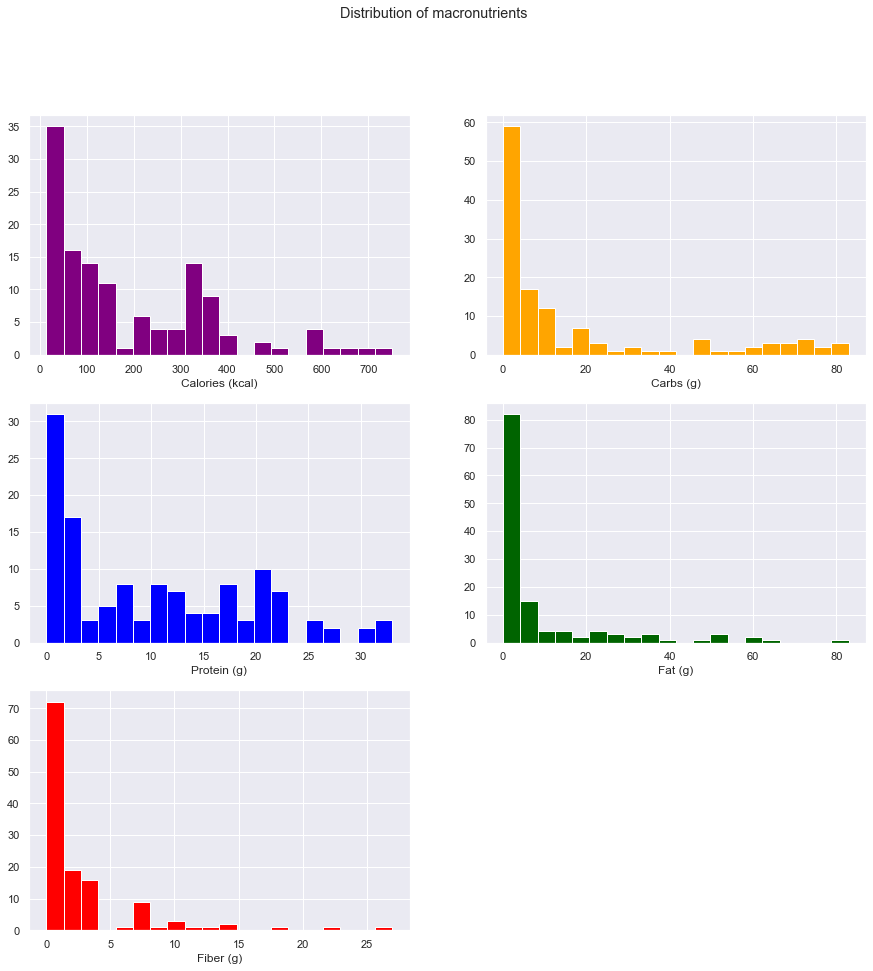

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context('notebook')


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15,15))
fig.suptitle('Distribution of macronutrients')

ax1.hist(solid_foods['Calories'], bins=20, color=macros_columns_dict['Calories'])
ax1.set(xlabel='Calories (kcal)')

ax2.hist(solid_foods['Carbs'], bins=20, color=macros_columns_dict['Carbs'])
ax2.set(xlabel='Carbs (g)')

ax3.hist(solid_foods['Protein'], bins=20, color=macros_columns_dict['Protein'])
ax3.set(xlabel='Protein (g)')

ax4.hist(solid_foods['Fat'], bins=20, color=macros_columns_dict['Fat'])
ax4.set(xlabel='Fat (g)')

ax5.hist(solid_foods['Fiber'], bins=20, color=macros_columns_dict['Fiber'])
ax5.set(xlabel='Fiber (g)')

ax6.axis('off') # Produces an empty plot at position (3,2)

plt.show()

**Fig. 1:** Histograms for each feature in the dataframe ```solid_foods```, representing the counting of calories, carbohydrates, proteins, fats and fibers. Notice that the vertical axis have different scales for each plot.

The above  histograms show that few foods in ```solid_foods``` have a high caloric value, or high amounts of each macronutrient or fibers. This may be seen from the left peak present at each plot, and from the lower bars at the right extreme of the x-axis: the left peak shows that most foods have a relatively low amount of calories, carbohydrates, proteins, fats or fibers, whereas just a few foods, counted at the far right part of the plot, contain high amounts of such features.

However, the distributions of calories and proteins do not present the same behaviour as we see in the other histograms. Carbohydrates, fibers and fats are all contained in a lower quantity in a small number of foods, and in a much higher quantity in just a few foods in ```solid_foods``` -- the histogram for fat being probably the most evident example of this pattern. Calories and proteins, on the other hand, are also contained in lower quantities in many foods, but present intermediate values in many others.

We consider next the relation between macronutrients and fibers, and caloric value of foods. First we shall address the dependence between these quantities considering portions of 100 g, and at a later part we shall rescale the features with portion sizes.

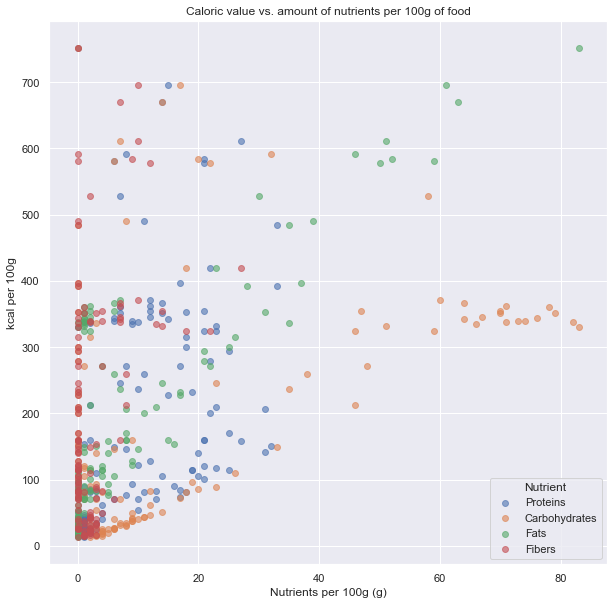

In [239]:
# Scatter plot of calories vs nutrients
alpha=0.6
fig, ax = plt.subplots(sharey=True, figsize=(10,10))
ax.set(title='Caloric value vs. amount of nutrients per 100g of food', 
       ylabel='kcal per 100g', 
       xlabel='Nutrients per 100g (g)')
ax1 = ax.scatter(x='Protein', y='Calories', data=solid_foods, alpha=alpha)
ax2 = ax.scatter(x='Carbs', y='Calories', data=solid_foods, alpha=alpha)
ax3 = ax.scatter(x='Fat', y='Calories', data=solid_foods, alpha=alpha)
ax4 = ax.scatter(x='Fiber',  y='Calories', data=solid_foods, alpha=alpha)

ax.legend((ax1, ax2, ax3, ax4), ('Proteins', 'Carbohydrates', 'Fats', 'Fibers'), loc='best', title='Nutrient')
plt.show()



**Fig. 2:** scatter plot of caloric value (in kilocalories) per amount of nutrients (in grams). The horizontal axist represents the amount of each nutrient (proteins, carbohydrates, fats and fibers). The vertical coordinate of each point then corresponds to the food's caloric value.

The above plot confirms the information we could extract from the histograms: it shows there are few foods with higher amount of nutrients per 100 g; notice, for instance, the lower point density at the right side of the plot, say beyond de 40g line. In addition, by combining all the foods into a single plot, we may see that carbohydrates and fats may be found in higher quantities than proteins and, even more, than fibers.

Even more interesting, however, are the apparent linear dependences between caloric value and amounts of fats and carbohydrates. In order to have a better view on this patter, we shall next plot the nutrient amounts versus caloric values separately. It is also worth noticing that there seems to be a lower bound in the caloric value for each nutrient. I.e., there is no food with an exceptionally high amount of fat, protein or carbohydrates and, at the same time, a very small amount of calories. In addition, we notice that fat-rich foods tend to be more caloric than carbohydrate-rich foods. This sugests that fats are more caloric per gram than carbohydrates. A similar analysis comparing proteins with the other two macronutrients is not that evident from the above plot. Moreover, many foods contain significant amounts of each nutrient, and since the subplots  are implemented for each feature individually, each food is not specified by a single point. Rather, each food is uniquely determined by its carbohydrates, fats, proteins and fibers contents, and hence by four points in the above plot, horizontaly aligned. Consequently, the caloric value depicted for each point is not associated to the points particular nutrient value (i.e. the y value is not completely defined by the x-value of each point), but from the sum of its amounts of each macronutrient.

The cell bellow produces linear plots exploring the dependence between caloric value and each nutrient amount. The code therefore produces a triple output: separate scatter plots similar to the above, a linear fit for each one, and a dataframe with parameters from the linear plots.

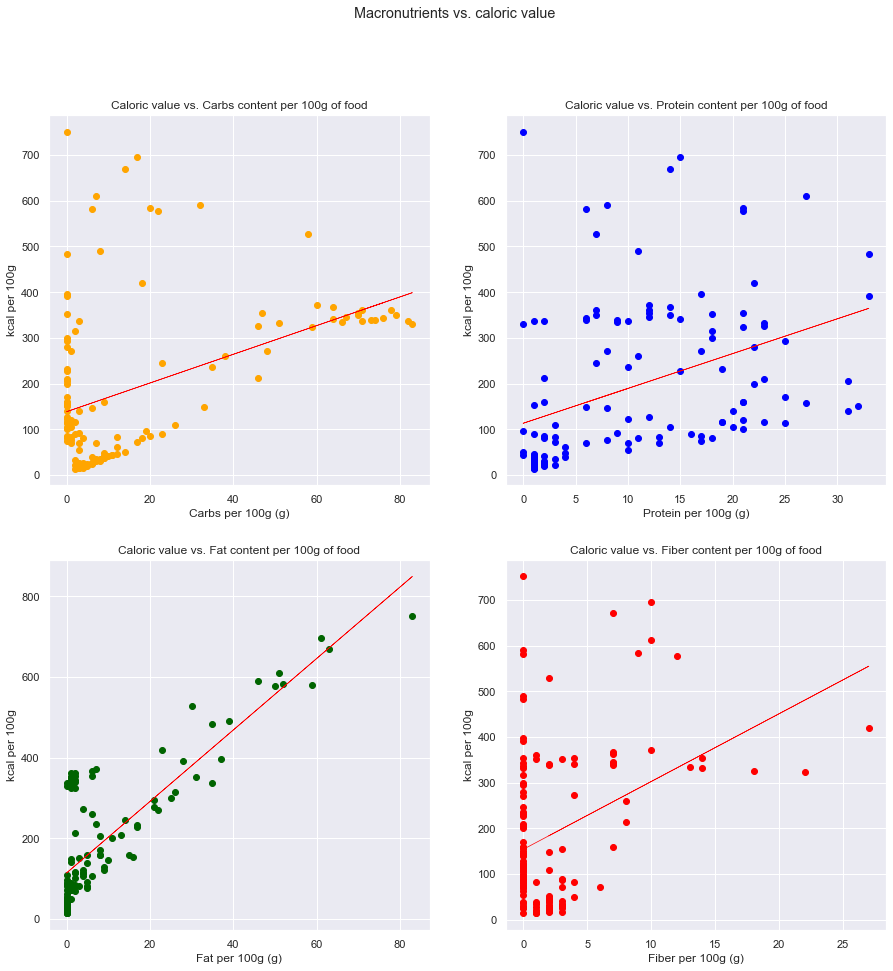

,angular coef,ang coef varianca,linear coef,lin coef variance
Carbs,3.137357,0.330322,138.510959,292.270792
Protein,7.620042,2.413716,113.211754,463.244973
Fat,8.858537,0.346537,114.165124,113.046809
Fiber,14.843496,10.390690,154.007495,275.677990


In [240]:
import numpy as np

# macros_columns.remove('Calories')
ax = dict.fromkeys(macros_columns) # Creates a dictionary with keys from macros_columns list and empty values
coef = dict.fromkeys(macros_columns) # Same; this will store the parameters form the linear fit
# print(macros_columns)
Y = np.array(solid_foods['Calories']) # Creates numpy array of y coordinates for the linear fit

fig, ((ax['Carbs'], ax['Protein']), (ax['Fat'], ax['Fiber'])) = plt.subplots(2,2, figsize=(15,15))
fig.suptitle('Macronutrients vs. caloric value in 100g of food')

# Loop over nutrients to make plots;
for column in macros_columns:
    if column == 'Calories':
        continue
    else:
        X = np.array(solid_foods[column]) # Creates numpy array of x coordinates for the linear fit
#     print(column, X)
        p, cov = np.polyfit(X, Y, deg=1, cov=True) # Produces linear fit coefficients and covariance matrix
        coef[column] = [p[0], cov[0,0], p[1], cov[1,1]] # stores coeficients and cov matriz into coef dictionary
        
        ax[column].scatter(x=column, y='Calories', data=solid_foods, color=macros_columns_dict[column]) #Scatterplot calories vs. nutrient
        ax[column].plot(solid_foods[column], p[0]*solid_foods[column] + p[1], 'red', linewidth=0.7) #Plots the linear fit
        ax[column].set(title='Caloric value vs. '+ column +' content per 100g of food', 
                    ylabel='kcal per 100g', 
                    xlabel= column + ' per 100g (g)')


plt.show()
del coef['Calories']
# print(coef)
coef_df = pd.DataFrame.from_dict(coef, orient='index', columns=['angular coef', 'ang coef varianca', 'linear coef', 'lin coef variance']) # creates a dataframe from the dictionary coef
display(coef_df)


# MAKE IT AS A DICTIONARY OF LISTS AND CONVERT INTO A DATAFRAME AT THE END:
# When I first wrote this cell, it started initializing an empty dataframe, whose cells were filled by the loop.
# After some troubles doing this and some search, I found a few stack overflow posts suggesting that this procedure was more
# expensive than keeping a list of lists until the end of the loop, and only then producing a dataframe.
# I then changed 'a list of lists' for a dictionary of lists because it seemed a bit easier to handle.


The angular coefficient for each linear plot above produces an estimate for the caloric value per gram of each macronutrient. Hence, according to the linear fits for nutrient amounts vs. caloric value, for instance, the caloric value of fat should be about $8.86 \pm 0.35 $ kcal / g, whereas it should be around $3.14 \pm 0.33$ kcal/ g of carbohydrates and $7.62 \pm 2.42$ kcal / g of protein.

Again, this analysis is not rigorously estimating the caloric value per gram of nutrient. In each plot, a point corresponds to some food in ```solid_foods```. Although its x-coordinate corresponds to a certain nutrient content, the vertical axis contains the total caloroc value per 100g of that food. In order to be able to state that there are X kcal/g of any nutrient, we should be able to plot the nutrient amount vs. the amount of calories due to that nutrient exclusively. This would be considerably different to what we are doping here.

That being said, a quick web search reveal that the caloric value per gram of fat is about 9 kcal, which is close (and withinh the variance range) to the value obtained. As for carbohydrates and proteins, this value should be around 4 kcal/ g for both nutrients. The elevated caloric value of fats in comparison to the other two macronutrients explains why its angular coefficient comes closer to a more accurate value. Nevertheless the total caloric value for each food in the plot is due to its total amount of proteins, carbohydrates and fats, since fats are more than twice as caloric as the other macornutrients, the total caloric value is much more influenced by the fats amount. This also explains why the fats plot presents a much more linear behaviour that that for carbohydrates and proteins, particularly; and why foods with a higher amounts of fats lie closer to the linear fit than those with lower amounts, and whose caloric values may come mostly from carnohydrates and proteins. A similar analysis applyes for carbohydrates.

Finally, we see that the linear plot for proteins and fibers is mostly meaningless, as the dots do not present a linear trend.

Since we have no access to uncertainties in the measurements of nutritinal values, we used the variance as an uncertainty parameter for the angular and linear coefficients.

One would expect that a food with no carbohydrates, fats and proteins should have zero calories. The linear coefficients, however, are all significantly gerater than zero. This again is due to the fact that we consider total caloric values only, and the caloric value of a certain food with low content of a certain nutrient, may have a high amount of another. In the carbohydrates plot, for instance, we may see quite many foods with lass than 20g, or even 10g of carbohydrates per 100g portion, and still with more than 400kcal. The dispersal of points for lower nutrients values translates into the high variances for the linear coefficients.

We complete this analysis on the instrinsic caloric values of macrunutrients from ```solid_foods``` by testing how well the parameters from the linear fit describe the total caloric value. In the cell bellow we plot the total caloric value vs. the result of

$$ (1). C_{std} = 4 \times ( Q_{carbs} + \times Q_{prot}) + 9 \times Q_{fats},$$
$$ (2). C_{obs} = a_{carbs} \times Q_{carbs} + a_{prot} \times Q_{prot} + a_{fats} \times Q_{fats},$$

where $a_{i}$ and $Q_i$ respectively correspond to the angular coefficient for the $i$ nutrient and its content in each food, per 100g portion.

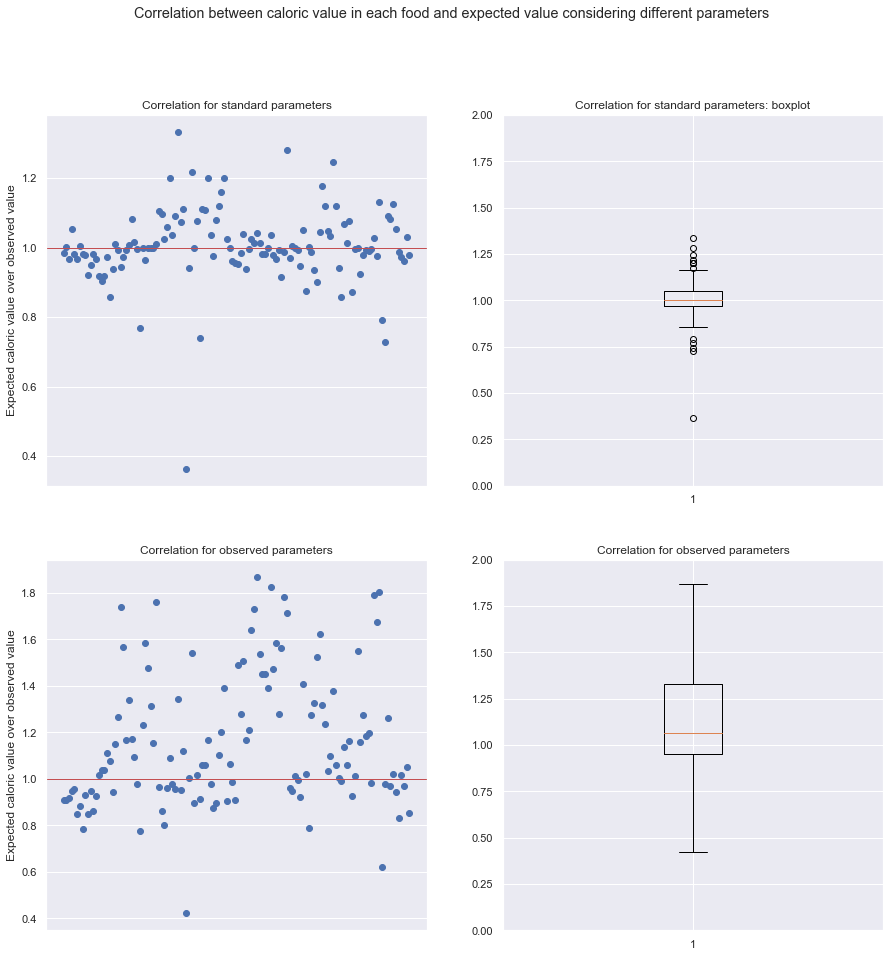

In [241]:
C_std = np.array(4*(solid_foods['Carbs'] + solid_foods['Protein']) + 9*solid_foods['Fat'])
# print(X_calories_theory, X_calories_theory.size)
Y_nparray = np.array(Y) # Reminder: Y = np.array(solid_foods['Calories'])
C_obs = np.array(coef_df.iloc[0,0]*solid_foods['Carbs'] + coef_df.iloc[1,0]*solid_foods['Protein']
                                 + coef_df.iloc[2,0]*solid_foods['Fat']) #numpy array from the above equation



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
fig.suptitle('Correlation between caloric value in each food and expected value considering different parameters')
ax1.plot(C_std / Y_nparray, 'bo')
ax1.axhline(y=1, color='r', linewidth=1)
ax1.xaxis.set_visible(False)
ax1.set(ylabel='Expected caloric value over observed value', title='Correlation for standard parameters')

ax2.boxplot(C_std / Y_nparray)
ax2.set(ylim=[0,2], title='Correlation for standard parameters: boxplot')

ax3.plot(C_obs / Y_nparray, 'bo')
ax3.axhline(y=1, color='r', linewidth=1)
ax3.xaxis.set_visible(False)
ax3.set(ylabel='Expected caloric value over observed value', title='Correlation for observed parameters')

ax4.boxplot(C_obs / Y_nparray)
ax4.set(ylim=[0,2], title='Correlation for observed parameters')


plt.show()



**Fig. 4:** Correlation between expected caloric values in foods, obtained via equations 1 or 2, and the observed caloric value, understood as the respective value in ```solid_foods['Calories]``` column. The plots in the first row were produced from equation (1) above, whereas those in the second one come from equation (2). The scatter plots represent the ration $C_{std} / Y$ (first row) and $C_{obs} / Y$ (second row), with Y the observed caloric value.

Once again we enphasize that this analysis does not provide an accurate method to obtain tha caloric value per gram of eanch macronutrient, as the second row of plots above shows. In order to affirm the precise amount of calories per gram of fat, protein or carbohydrate, we would have to consider each macronutrient separately, whereas most foods in tha dataset we consider contain all of them in different proportions. In this part of the notebook we intended to give a general survey and description of dfoods within a particular, personal diet. From the lines above, however, we could see how the caloric value oper gram of fat overcomes the amount of calories in a gram of protein or carbohydrate.

So far we have only considered 100g portions of each solid food. In order to better understand the diet as a whole, we should also consider actual portion sizes. We shall address these in the bellow.

## Nutrients distribution per portion size

Columns ```'Portion_size_g'``` and ```'Portion_size_ml'``` in the dataset contain portion sizes as percentuals of a 100g portion. I.e., if my personal, regular portion of pasta is about 120g of pasta (I am perfectly aware the Italian standard would be 80g, but I seldom eat *primo* and *secondo piato* at home), then the ```'Portion_size_g'```value relative to pasta is 1.2. As portion sizes are not in the ```solid_foods``` dataframe, this column has to be added. In addition, the nutritional values have to be adjusted to the new portion sizes. We shall create a new dataframe, containing nutritional values w.r.t. the given portions of foods.

In [248]:
# Create new dataframe, adding portion_size_g to solid_foods
solid_foods_portion = pd.merge(df[['Name', 'Portion_size_g']].set_index('Name'), solid_foods, on='Name', how='inner')

for column in macros_columns:
    solid_foods_portion[column + '_per_portion'] = solid_foods_portion[column] * solid_foods_portion['Portion_size_g']
    solid_foods_portion.drop(column, axis=1, inplace=True)
    

display(solid_foods.shape)
display(solid_foods_portion.shape)
display(solid_foods_portion.head())

(128, 7)

(128, 8)

,Portion_size_g,Category_1,Category_names,Calories_per_portion,Carbs_per_portion,Protein_per_portion,Fat_per_portion,Fiber_per_portion
Name,,,,,,,,
Flour 0,0.3,0,"Wheats, rices, potatoes and similar",101.4,21.3,3.0,0.3,0.6
Flour 00,0.3,0,"Wheats, rices, potatoes and similar",102.0,22.2,2.7,0.3,0.6
Whole wheat flour,0.3,0,"Wheats, rices, potatoes and similar",108.6,21.3,3.6,0.6,2.1
Potatoes,2.0,0,"Wheats, rices, potatoes and similar",220.0,52.0,6.0,0.0,4.0
Pasta,1.2,0,"Wheats, rices, potatoes and similar",421.2,84.0,16.8,1.2,3.6


We can now analyse the caloric value vs. nutrients amounts distributions, with respect to the actual portion sizes. In the lines bellow we have written codes plotting figures quite similars to some in the above. We have chosen to keep the code different, however (just in order to compare different methods).

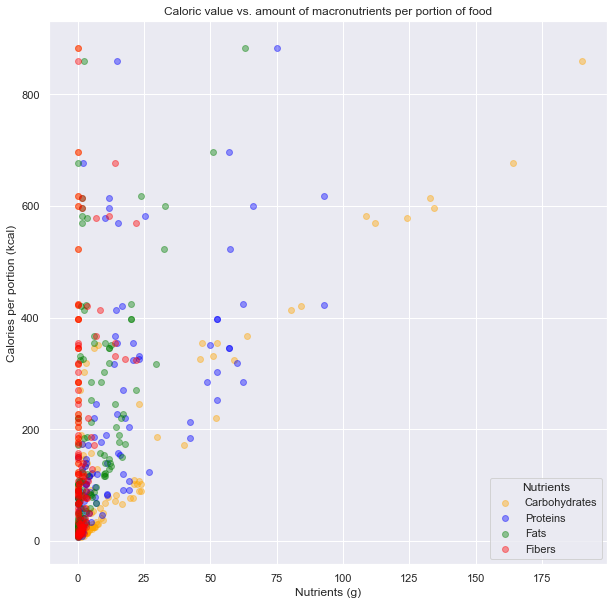

In [258]:
macronutrients_per_portion = {'Calories_per_portion':'purple', 'Carbs_per_portion':'orange', 'Protein_per_portion':'blue', 'Fat_per_portion':'green', 'Fiber_per_portion':'red'}

alpha=0.6

fig, ax = plt.subplots(figsize=(10,10))
for column in macronutrients_per_portion.keys():
    if column == 'Calories_per_portion':
        continue
    else:
        ax.scatter(x=column, y='Calories_per_portion', data=solid_foods_portion, alpha=0.4, color = macronutrients_per_portion[column])

ax.set(xlabel='Nutrients (g)', ylabel='Calories per portion (kcal)', title='Caloric value vs. amount of macronutrients per portion of food')
ax.legend(('Carbohydrates', 'Proteins', 'Fats', 'Fibers'), title='Nutrients')

plt.show()

**Fig. 5:** scatter plot of caloric value (in kilocalories) per nutrients content in a given portion of food (in grams). The horizontal axist represents the amount of each nutrient (proteins, carbohydrates, fats and fibers). The vertical coordinate of each point then corresponds to the food's portion caloric value.

Though the plot above resambles that in fig. 2, we can already see some differences: the dependence of caloric value or carbohydrates amount looks much more linear than when we considered standard 100g portion. Moreover, we see no food with an exceptionally high amount of any nutrient, and at the same time a very low caloric value. This asopect is even more evident in the plot just above than it was in figure 2.

We next consider separat plots again.

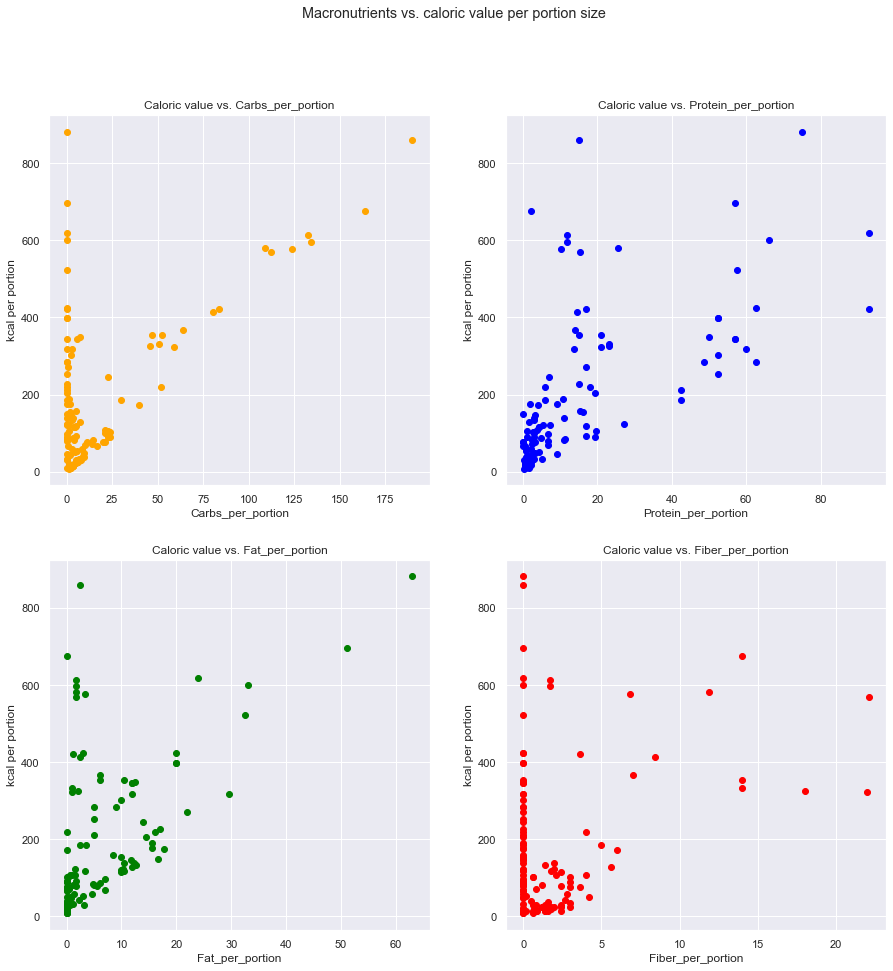

In [260]:
ax = dict.fromkeys(macros_columns)
# print(ax)
fig, ((ax['Carbs_per_portion'], ax['Protein_per_portion']), (ax['Fat_per_portion'], ax['Fiber_per_portion'])) = plt.subplots(2,2, figsize=(15,15))
fig.suptitle('Macronutrients vs. caloric value per portion size')

for column in macronutrients_per_portion.keys():
    if column == 'Calories_per_portion':
        continue
    
    else:
        ax[column].scatter(x=column, y='Calories_per_portion', data=solid_foods_portion,color=macronutrients_per_portion[column])
        ax[column].set(title='Caloric value vs. '+ column, 
                   ylabel='kcal per portion', 
                   xlabel= column)

plt.show()

The most meaningful difference with respect to 100g portions may be seen in the caloric value vs. proteins per portion plot, which does not present points spread almost as if at random, as in the respective plot of figure 3.

It is worth noticing, once again, that no plot presents any point with very high amount of nutrient and very low caloric value per portion. This may be pointing to the fact that, considering the foods and respective portion sizes described in the dataframe, there are no such a thing as a "super food" in the diet. Though this may be very intuitive, only 10 minutes on Instagram or Youtube will reveal several posts and videos arguing that foods like greek yogurt, salmon and avocado are keys to losing fat and keeping muscle mass. At the level of macronutrients, however, is is impossible to spot particularly exceptional foods in the above plots -- as it was also when we considered standard 100g portions. It may be that these or other foods keep one satisfied for a much longer period, or that they are completely different of other foods at the micronutrients level, which goes beyond the scope of this notebook. However, it is still good to question (if not debunk) the dietary culture which affirms that a particular food is *the key* to weight loss: more nutrients implies more calories, and this is true even for proteins.

A similar question may be stated when looking at the caloric value vs. fibers amount: can one spot the salad? There is also no food with an abnormal amount of fibers and almost no calories. Again, this was also the case when we considered 100g portions. Since fibers (if I am not mistaken) are non-digestible carbohydrates, perhaps a higher amount of fibers is associated to a hugher amount of (digestible) carbohydrates.

## Categories evaluation

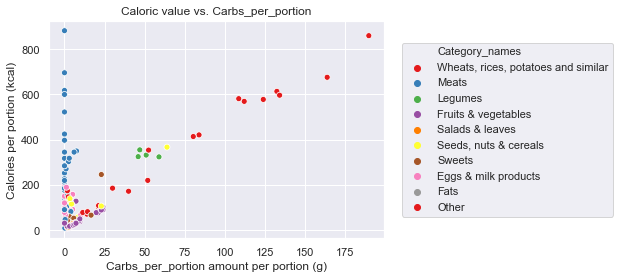

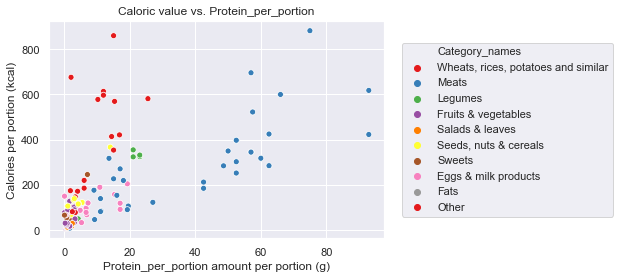

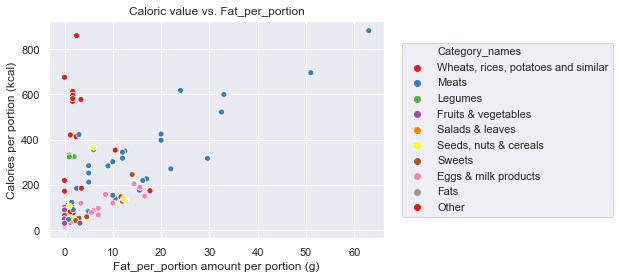

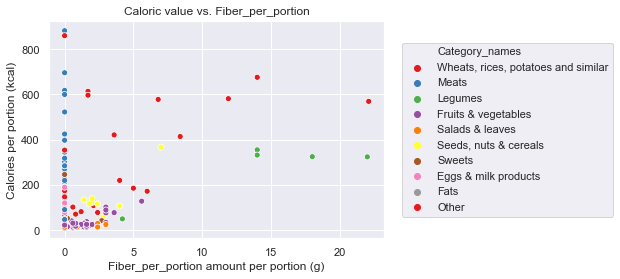

In [246]:
import seaborn as sns

current_palette = 'Set1'

# columns_portion = ['Calories_per_portion', 'Carbs_per_portion', 'Protein_per_portion', 'Fat_per_portion', 'Fiber_per_portion']
# for column in columns_portion:
#     if column == 'Calories_per_portion':
#         continue
#     else:
#         for cat in solid_foods_portion['Category_1']:
#             print(cat)
# #         ax= sns.scatterplot(data=solid_foods_portion, x=column, y='Calories_per_portion', hue='Category_1', legend='full', palette=current_palette)
# #         plt.xlabel(column + ' amount per portion (g)')
# #         plt.ylabel('Calories per portion (kcal)')
# #         plt.title('Caloric value vs. ' + column)
# #         plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), labels=['q','w','e','r','t','y','u','i','o','p'])
# #         plt.show()


columns_portion = ['Calories_per_portion', 'Carbs_per_portion', 'Protein_per_portion', 'Fat_per_portion', 'Fiber_per_portion']
for column in columns_portion:
    if column == 'Calories_per_portion':
        continue
    else:
        ax= sns.scatterplot(data=solid_foods_portion, x=column, y='Calories_per_portion', hue='Category_names', size=None, legend='full', palette=current_palette)
        plt.xlabel(column + ' amount per portion (g)')
        plt.ylabel('Calories per portion (kcal)')
        plt.title('Caloric value vs. ' + column)
        plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5))
        plt.show()


In [247]:
#sns.set_style('whitegrid')
for column in columns:
    if column == 'Calories':
        continue
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        ax= sns.scatterplot(data=solid_foods, x=column, y='Calories', hue='Category_names', size=None, legend='full', palette=current_palette)
        ax.set(ylabel='Calories per 100g (kcal)', xlabel=(column + ' amount per 100g (g)'), xlim=(-4, 1.1*solid_foods[column].max()), ylim=(-10, 900))
        plt.title('Caloric value vs. ' + column)
        plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5))
        plt.show()


NameError: name 'columns' is not defined